In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from model import ResNeXt, Discriminator
from dataloader import get_dataloaders
from ssim import ssim
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'


# Seed
manual_seed = 0
random.seed(manual_seed)
torch.manual_seed(manual_seed)

# Hyperparameters
lr = 0.0002
num_epochs = 10000
device = torch.device("cuda")

# Dataloaders
train_dataloader, test_dataloader = get_dataloaders()

# Initialize models
generator = ResNeXt().to(device)
discriminator = Discriminator().to(device)

# Initialize optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss functions
criterion = nn.MSELoss()
criterion_D = nn.BCELoss()

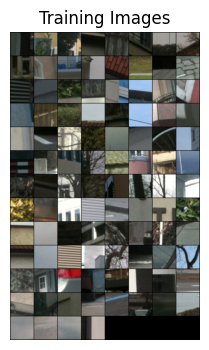

In [2]:
phone, dslr = next(iter(train_dataloader))
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Images")
# display the images with shape of torch.Size([3, 100, 100, 32])
plt.imshow(np.transpose(vutils.make_grid(phone), (1,2,0)))

In [3]:

gen_losses = []
disc_losses = []
num_epochs = 1000

# Load the generator checkpoint
checkpoint_G = torch.load('checkpoints/generator_epoch_94.pth')
generator.load_state_dict(checkpoint_G)

# Load the discriminator checkpoint
checkpoint_D = torch.load('checkpoints/discriminator_epoch_94.pth')
discriminator.load_state_dict(checkpoint_D)

# Set the starting epoch
start_epoch = 94


for epoch in range(start_epoch, num_epochs):
    for i, (phone_images, dslr_images) in enumerate(train_dataloader):

        phone_images, dslr_images = phone_images.to(device), dslr_images.to(device)
        current_batch_size = phone_images.size(0)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        enhanced_images = generator(phone_images)
        total_gen_loss = criterion(enhanced_images, dslr_images)

        total_gen_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        outputs_real = discriminator(dslr_images)

        # Adjust the label size to match the current batch size
        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)

   
        # Discriminator loss for real images
        loss_disc_real = criterion_D(outputs_real, real_labels)

        # Discriminator loss for fake (generated) images
        outputs_fake = discriminator(enhanced_images.detach())
        loss_disc_fake = criterion_D(outputs_fake, fake_labels)

        # Total discriminator loss
        total_disc_loss = (loss_disc_real + loss_disc_fake) / 2
        total_disc_loss.backward()
        optimizer_D.step()


        if (i+1) % 50 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], "
                f"Gen Loss: {total_gen_loss.item()}, Disc Loss: {total_disc_loss.item()}")

            # Save model checkpoints
            torch.save(generator.state_dict(), f'checkpoints/generator_epoch_{epoch}.pth')
            torch.save(discriminator.state_dict(), f'checkpoints/discriminator_epoch_{epoch}.pth')

            # Example of saving a sample enhanced image
            sample_enhanced = enhanced_images[0]
            sample_original = phone_images[0]
            comparison = torch.cat((sample_original, sample_enhanced), dim=2)
            save_image(comparison, os.path.join('results', f'sample_epoch_{epoch}.jpg'))

        gen_losses.append(total_gen_loss.item())
        disc_losses.append(total_disc_loss.item())


Epoch [100/1000], Step [50/50], Gen Loss: 0.3412822186946869, Disc Loss: 0.00012708482972811908
Epoch [101/1000], Step [50/50], Gen Loss: 0.2816835343837738, Disc Loss: 0.0001462631771573797
Epoch [102/1000], Step [50/50], Gen Loss: 0.27087080478668213, Disc Loss: 8.066176087595522e-05
Epoch [103/1000], Step [50/50], Gen Loss: 0.29008907079696655, Disc Loss: 6.417243275791407e-05
Epoch [104/1000], Step [50/50], Gen Loss: 0.21458324790000916, Disc Loss: 0.0001438264298485592
Epoch [105/1000], Step [50/50], Gen Loss: 0.2089148908853531, Disc Loss: 6.46687185508199e-05
Epoch [106/1000], Step [50/50], Gen Loss: 0.22053290903568268, Disc Loss: 8.068316674325615e-05
Epoch [107/1000], Step [50/50], Gen Loss: 0.2566843628883362, Disc Loss: 6.20739592704922e-05
Epoch [108/1000], Step [50/50], Gen Loss: 0.19024810194969177, Disc Loss: 5.142415102454834e-05
Epoch [109/1000], Step [50/50], Gen Loss: 0.17401452362537384, Disc Loss: 8.160156721714884e-05
Epoch [110/1000], Step [50/50], Gen Loss: 0.1

KeyboardInterrupt: 

In [ ]:

# Plot the generator and discriminator losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="G")
plt.plot(disc_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()




In [ ]:
# Save the model
torch.save({
    'epoch': epoch,
    'model_state_dict': generator.state_dict(),
    'optimizer_state_dict': optimizer_G.state_dict(),
    'loss': g_loss,
}, f"generator_epoch_{epoch}.pth")


NameError: name 'g_loss' is not defined

In [ ]:
checkpoint = torch.load("generator_epoch_49.pth")
generator.load_state_dict(checkpoint['model_state_dict'])
optimizer_G.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']


In [ ]:
from torchvision.utils import save_image
generator.eval()
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        imgs_iphone, imgs_dslr = data
        imgs_iphone, imgs_dslr = imgs_iphone.to(device), imgs_dslr.to(device)
        gen_imgs = generator(imgs_iphone)
        
        save_image(gen_imgs, f"images/image_{i}.jpg")
